In [ ]:
!python3 --version

Python 3.7.13


In [ ]:
!sudo apt install libspatialindex-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!pip install pyinterpolate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd

from pyinterpolate.io_ops import prepare_areal_shapefile, get_points_within_area  # Prepare data
from pyinterpolate.semivariance import calculate_semivariance  # Experimental semivariogram
from pyinterpolate.semivariance import RegularizedSemivariogram  # Semivariogram regularization class
from pyinterpolate.semivariance import TheoreticalSemivariogram
from pyinterpolate.kriging import ArealKriging

import matplotlib.pyplot as plt

In [ ]:
BLOCKS = '/content/drive/MyDrive/data_geopython_2022/cancer_data.shp'
POINT_SUPPORT = '/content/drive/MyDrive/data_geopython_2022/cancer_population_base.shp'

In [ ]:
BLOCK_ID = 'FIPS'
BLOCK_VAL_COL = 'rate'
PS_VAL_COL = 'POP10'

In [ ]:
areal_data_prepared = prepare_areal_shapefile(BLOCKS, BLOCK_ID, BLOCK_VAL_COL)

In [ ]:
points_in_area = get_points_within_area(BLOCKS,
                                        POINT_SUPPORT,
                                        areal_id_col_name=BLOCK_ID,
                                        points_val_col_name=PS_VAL_COL)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pyinterpolate/io_ops/get_points_within_area.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(output_points_within_area)


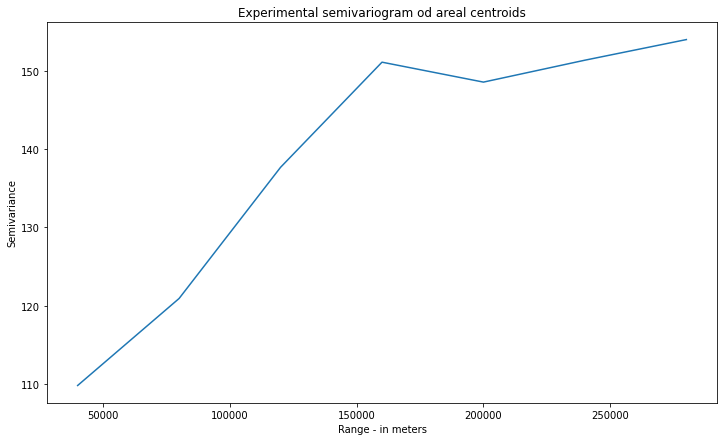

In [ ]:
maximum_range = 300000
step_size = 40000

dt = areal_data_prepared[:, 2:]  # x, y, val
exp_semivar = calculate_semivariance(data=dt, step_size=step_size, max_range=maximum_range)

# Plot experimental semivariogram

plt.figure(figsize=(12, 7))
plt.plot(exp_semivar[:, 0], exp_semivar[:, 1])
plt.title('Experimental semivariogram od areal centroids')
plt.xlabel('Range - in meters')
plt.ylabel('Semivariance')
plt.show()

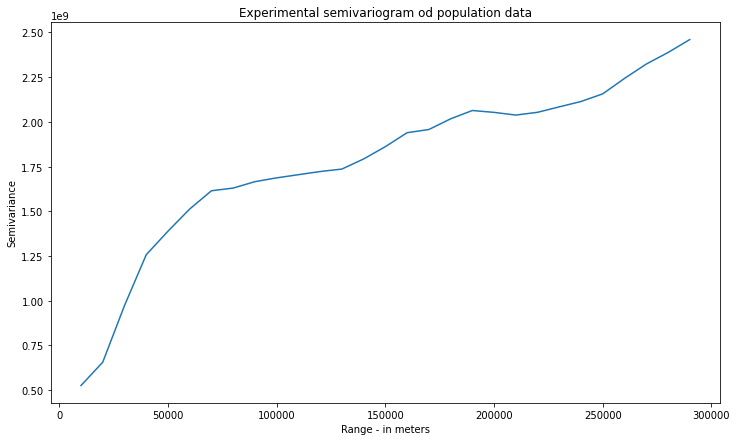

In [ ]:
def build_point_array(points):
    a = None

    for rec in points:
        if a is None:
            a = rec.copy()
        else:
            a = np.vstack((a, rec))

    return a

maximum_point_range = 300000
step_size_points = 10000


pt = build_point_array(points_in_area[:, 1])  # x, y, val
exp_semivar = calculate_semivariance(data=pt, step_size=step_size_points, max_range=maximum_point_range)

# Plot experimental semivariogram

plt.figure(figsize=(12, 7))
plt.plot(exp_semivar[:, 0], exp_semivar[:, 1])
plt.title('Experimental semivariogram od population data')
plt.xlabel('Range - in meters')
plt.ylabel('Semivariance')
plt.show()

In [ ]:
reg_mod = RegularizedSemivariogram()

reg_mod.fit(areal_data=areal_data_prepared,
            areal_step_size=step_size,
            max_areal_range=maximum_range,
            point_support_data=points_in_area,
            weighted_lags=True,
            store_models=False)

/usr/local/lib/python3.7/dist-packages/pyinterpolate/semivariance/semivariogram_fit/fit_semivariance.py:436: UserWarning: WARNING: linear model fitted to the experimental variogram is better than the core models!
  warnings.warn(warning_msg)
/usr/local/lib/python3.7/dist-packages/pyinterpolate/semivariance/areal_semivariance/block_to_block_semivariance/calculate_block_to_block_semivariance.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  output_array = np.array([block_to_block_semivariance, blocks_ids])


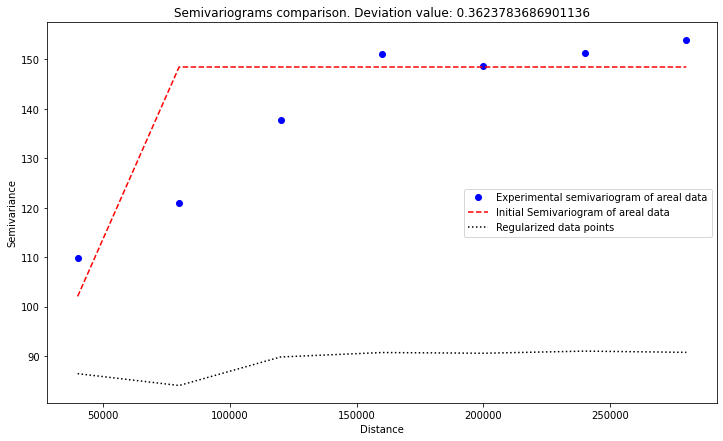

In [ ]:
lags = reg_mod.experimental_semivariogram_of_areal_data[:, 0]

plt.figure(figsize=(12, 7))
plt.plot(lags, reg_mod.experimental_semivariogram_of_areal_data[:, 1], 'ob')
plt.plot(lags, reg_mod.initial_theoretical_model_of_areal_data.predict(lags), color='r', linestyle='--')
plt.plot(lags, reg_mod.initial_regularized_model, color='black', linestyle='dotted')
plt.legend(['Experimental semivariogram of areal data', 'Initial Semivariogram of areal data',
            'Regularized data points'])
plt.title('Semivariograms comparison. Deviation value: {}'.format(reg_mod.initial_deviation))
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

In [ ]:
reg_mod.transform(max_iters=5)

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pyinterpolate/semivariance/areal_semivariance/block_to_block_semivariance/calculate_block_to_block_semivariance.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  output_array = np.array([block_to_block_semivariance, blocks_ids])
100%|██████████| 5/5 [05:26<00:00, 65.22s/it]


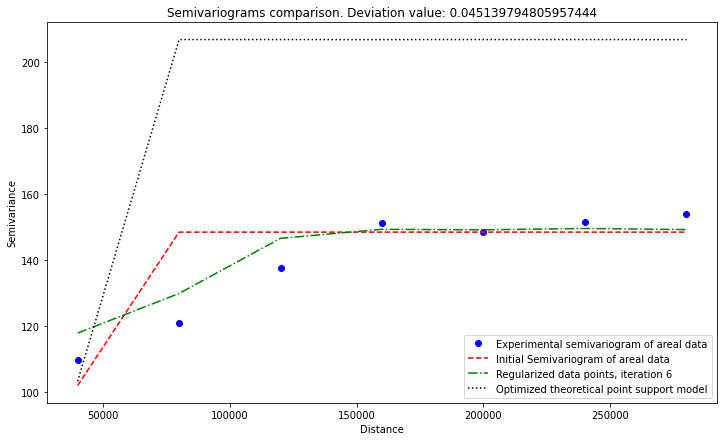

In [ ]:
lags = reg_mod.experimental_semivariogram_of_areal_data[:, 0]
plt.figure(figsize=(12, 7))
plt.plot(lags, reg_mod.experimental_semivariogram_of_areal_data[:, 1], 'bo')
plt.plot(lags, reg_mod.initial_theoretical_model_of_areal_data.predict(lags), color='r', linestyle='--')
plt.plot(lags, reg_mod.optimal_regularized_model, color='g', linestyle='-.')
plt.plot(lags, reg_mod.optimal_theoretical_model.predict(lags), color='black', linestyle='dotted')
plt.legend(['Experimental semivariogram of areal data', 
            'Initial Semivariogram of areal data',
            'Regularized data points, iteration {}'.format(reg_mod.iter),
            'Optimized theoretical point support model'])
plt.title('Semivariograms comparison. Deviation value: {}'.format(reg_mod.optimal_deviation))
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()

In [ ]:
transformed_variogram = '/content/drive/MyDrive/data_geopython_2022/transformed_variogram'

In [ ]:
reg_mod.export_regularized_model(transformed_variogram)

In [ ]:
reg_mod = None

In [ ]:
variogram = TheoreticalSemivariogram()

In [ ]:
variogram.import_model(transformed_variogram)

In [ ]:
number_of_obs = 8
radius = 30000

# Get crs

gdf_crs = gpd.read_file(BLOCKS).crs

kriging_model = ArealKriging(
    semivariogram_model=variogram,
    known_areas=areal_data_prepared,
    known_areas_points=points_in_area,
    kriging_type='atp')

smoothed_area = kriging_model.regularize_data(number_of_neighbours=number_of_obs,
                                              max_search_radius=radius,
                                              data_crs=gdf_crs)

/usr/local/lib/python3.7/dist-packages/pyinterpolate/transform/prepare_kriging_data.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  output_arr = np.array([unknown_point_val, otp])
/usr/local/lib/python3.7/dist-packages/pyinterpolate/transform/prepare_kriging_data.py:406: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  output_data = np.array(points_vals)
/usr/local/lib/python3.7/dist-packages/pyinterpolate/transform/prepare_kriging_data.py:267: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of

<AxesSubplot:>

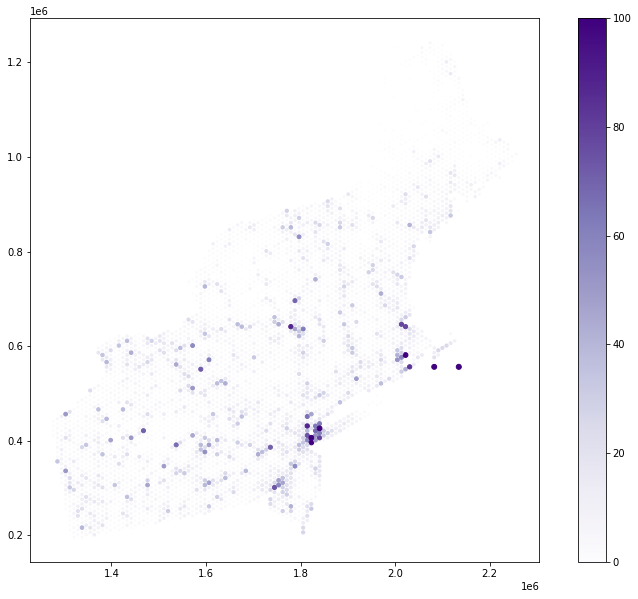

In [ ]:
fs = (14, 10)
output_map = smoothed_area.copy()

output_map.plot(column='reg.est', cmap='Purples', legend=True, figsize=fs, markersize=2*np.sqrt(output_map['reg.est']), vmin=0, vmax=100)

In [ ]:
output_map

,id,geometry,reg.est,reg.err,rmse
0,25019,POINT (2117322.312 556124.507),0.096617,7.599661,28.541554
1,25019,POINT (2134642.820 556124.507),163.561829,7.638901,28.541554
2,36121,POINT (1424501.989 556124.507),5.579363,7.386063,27.346345
3,36121,POINT (1424501.989 546124.507),6.442881,7.631584,27.346345
4,36121,POINT (1433162.243 561124.507),20.087414,7.346801,27.346345
...,...,...,...,...,...
4955,36033,POINT (1727610.881 821124.507),0.457454,10.363275,21.136968
4956,36033,POINT (1727610.881 811124.507),3.378145,9.079633,21.136968
4957,36033,POINT (1727610.881 791124.507),5.152009,0.000000,21.136968
4958,36033,POINT (1727610.881 781124.507),0.000000,0.000000,21.136968
